
# Maximal Representative Subsampling

### Table of contents

1. [Sampling Method](#sampling)
2. [Preprocessing](#prep)
    1. [GBS](#gbs)
    2. [Allensbach](#allensbach)
    3. [GESIS](#gesis)
    
3. [US National Census (Income)](#us)
    - [With Selection Bias](#sub1)
    - [Without Selection Bias](#sub2)
4. [Allensbach](#allensbach)

In [1]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy import stats

import pandas as pd
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide = 'ignore')
import random

path = Path(os.getcwd()).parent

<div class="alert alert- block alert-warning"><b>Tip:</b> Use blue boxes. If bla. </div>

In [2]:
def temp_sample(softmax, temperature, drop):
    '''Temperature Sampling'''

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

def plot_results(score, t, n, baseline):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]
    
    if baseline == True:
        t = 'random'

    #plots([k[0] for k in ks], 'KS stats')
    #plots([k[1] for k in ks], 'KS P-value')
    plots(auc, t, [n[0]-i for i in n])
    
def plots(arr, t, n):
    
    plt.plot(n, arr, label=t)
    plt.plot(n, len(arr)*[0.5], linestyle='--')
    plt.xlabel("removed instances")
    plt.ylabel("AUC")
    plt.grid()
    plt.title('US National Census (Income)')

### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [3]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:] # drop first row from test set

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country'] # Categorical to Numerical

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 - >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

#rep = df.copy(deep=True)
rep = pd.concat([df_low.head(15890).copy(deep=True),
                 df_high.head(5000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(15890).copy(deep=True),
                    df_high.tail(5000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

data = pd.concat([nonrep, rep], sort=True)

cols = list(data.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in cols:
        cols.remove(m)
        
data.head()

Rep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  <=50K    15890
 >50K      5000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
15027,<=50K,65,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,180280.0,1
7720,<=50K,30,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,81282.0,1
16090,<=50K,51,4064.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,86332.0,1
22066,<=50K,30,0.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,27051.0,1
34317,<=50K,37,3137.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,183735.0,1


41780, 41682, 41583, 41483, 41383, 41284, 41184, 41084, 40984, 40884, 40784, 40684, 40585, 40485, 40386, 40286, 40186, 40086, 39986, 39888, 39788, 39688, 39588, 39489, 39389, 39289, 39190, 39090, 38990, 38891, 38791, 38691, 38591, 38491, 38391, 38291, 38192, 38093, 37993, 37893, 37793, 37693, 37593, 37493, 37394, 37294, 37195, 37095, 36995, 36895, 36796, 36696, 36597, 36497, 36398, 36299, 36199, 36100, 36001, 35901, 35802, 35702, 35603, 35504, 35405, 35306, 35206, 35106, 35006, 34906, 34806, 34706, 34607, 34507, 34407, 34308, 34208, 34108, 34008, 33908, 33808, 33709, 33609, 33509, 33409, 33310, 33210, 33110, 33010, 32910, 32810, 32710, 32610, 32510, 32410, 32311, 32212, 32112, 32013, 31914, 31814, 31714, 31614, 31515, 31416, 31318, 31218, 31118, 31021, 30921, 30821, 30721, 30622, 30523, 30423, 30324, 30224, 30124, 30024, 29924, 29824, 29725, 29625, 29525, 29426, 29326, 29226, 29127, 29027, 28927, 28828, 28729, 28629, 28530, 28430, 28331, 28233, 28134, 28036, 27937, 27837, 27739, 27639,

<IPython.core.display.Javascript object>


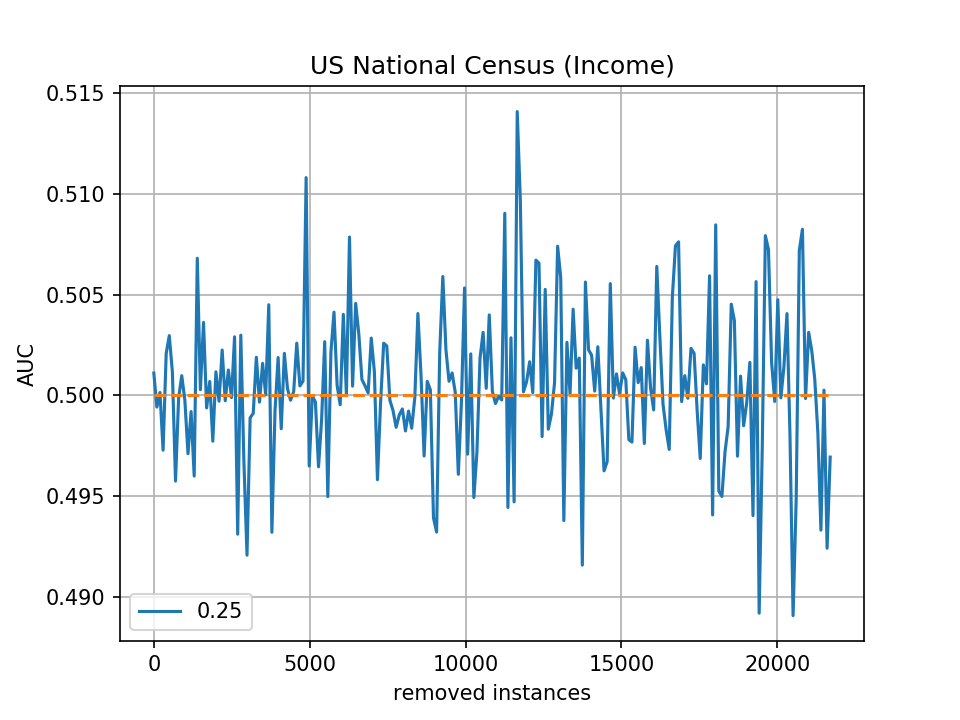

In [4]:
data_base = data.copy(deep=True)

n_drop = 100
limit = 10000
ensemble_size = 2

baseline = False

for t in np.arange(0.25, 0.35, 0.1):

    temperature = min(t, 1)
    score = []
    n = []
    
    data = data_base.copy(deep=True)
    
    while (min(len(data[data.label == 1]), 
               len(data[data.label == 0]))):    

        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)

        data = pd.concat([nonrep, rep], sort=True)
        
        train, test = train_test_split(data, test_size=0.3)
        #bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
        test = pd.DataFrame(test)

        preds = [0]*len(test)
        for _ in range(ensemble_size):
            
            dt = DecisionTreeClassifier(max_depth=1)
            
            bootstrap = pd.DataFrame(train).sample(len(train), replace=True)
            dt.fit(bootstrap[cols], bootstrap.label)
            
            prob = [p[1] for p in dt.predict_proba(test[cols])]
            preds = [pre + pro for pre, pro in zip(preds, prob)]

        preds = [f/ensemble_size for f in preds]
        
        score.append((test.label, preds))
        n.append(len(data.index))
        
        print(len(data.index), end=', ')

        if baseline == True: 
            preds = [random.random() for _ in preds]
            
        test['removed'] = temp_sample(preds, temperature, n_drop)
        test = test[test.removed == 0]
        test.drop('removed', axis=1)

        data = pd.concat([train, test], sort=True)

    plot_results(score, round(temperature, 2), n, baseline)
    baseline = False
    
plt.legend(loc='lower left')
plt.savefig('US_results11.png')
plt.show()

kurze Anmerkungen zu den Experimenten und Ergebnissen auf US National Census:

- mit sinkenden Temperaturen steigt die WSK dieselbe Instanz über Softmax Temperature Sampling zu wählen. Es werden also weniger Instanzen pro Iteration rausfallen. Insgesamt müssen also mehr Modelle trainiert werden, also der Algorithmus läuft länger.
- mit steigenden Temperaturen nimmt die Varianz wegen abnehmender Größe vom Datensatz zu.
- wenn man mit zwei repräsentativen Datensätzen startet (selbes Verhältnis arm zu reich), sind die AUCs unabhängig von den Temperaturen konstant bei 0.5. Zu jedem Zeitpunkt ist der übrige Datensatz repräsentativ.
- 0.2 scheint eine sinnvolle Temperatur zu sein. Weniger kostet mehr Rechenzeit, führt aber zu keinem stärkere Reduktion in AUCs. Mehr "verwischt" die Modellvorhersagen zu sehr, sodass es bereits mehr in Richtung "Random Entfernen" geht.
- die Ergebnisse legen die Vermutung nahe, dass sich die ROC Kurve eigentlich zu keinem Zeitpunkt unter 0.5 bewegen dürfte. Man kann natürlich 1-AUC verwenden, aber das löst das Problem nicht. Vielleicht stimmt was mit GESIS-GBS nicht. Allensbach und US Census sind nachweislich besser für den Algorithmus geeignet. Matching der Daten könnte das Problem bereits entfernen.

In [5]:
data[data['label']==0]['Above/Below 50K'].value_counts()

 <=50K    7645
 >50K     2384
Name: Above/Below 50K, dtype: int64

In [6]:
data[data['label']==1]['Above/Below 50K'].value_counts()

 <=50K    7526
 >50K     2431
Name: Above/Below 50K, dtype: int64